# Bank Customer Churn Prediction

## 1. Project Setup and Data Loading

In this initial step, we will set up the environment by importing the necessary libraries for data manipulation, visualization, and machine learning. We will then load the dataset and perform a preliminary inspection to understand its structure, data types, and basic statistics.

In [15]:
# --- SETUP AND INITIAL DATA LOADING ---

# For Data Manipulation
import pandas as pd
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Data ---
sns.set_style("whitegrid")

try:
    df = pd.read_csv('data/Churn_Modelling.csv')
    print("Dataset loaded successfully.")
    
    # Display initial information
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- First 5 Rows ---")
    print(df.head())

except FileNotFoundError:
    print("Error: 'Churn_Modelling.csv' not found. Please check the file path.")

Dataset loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB

--- First 5 Rows ---
   RowNumber  Cust

## 2. Exploratory Data Analysis (EDA)

In this section, we will dive deep into the dataset to uncover patterns and relationships. We'll start by analyzing the distribution of our target variable, `Exited`, and then explore how different customer attributes correlate with churn.

Overall Churn Rate:
Exited
0    79.624075
1    20.375925
Name: proportion, dtype: float64

This shows a class imbalance, with about 20% of customers having churned.


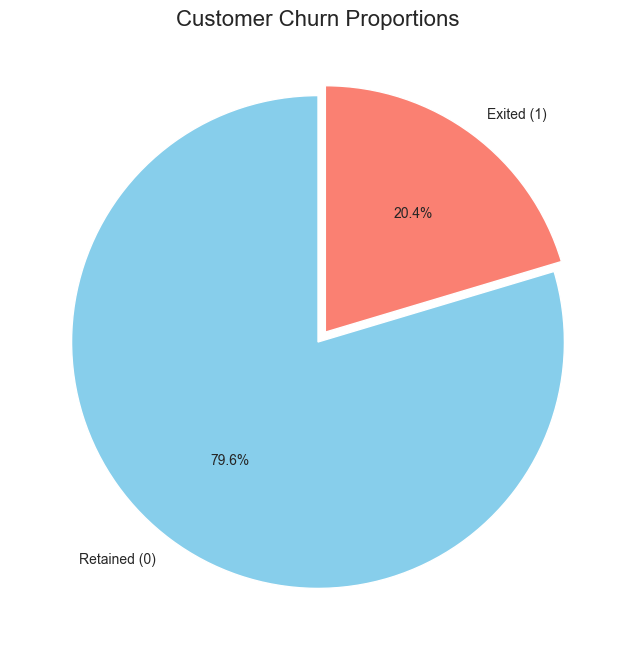

In [16]:
# --- OVERALL CHURN DISTRIBUTION ---

# Calculate the churn ratio
churn_rate = df['Exited'].value_counts(normalize=True) * 100

print(f"Overall Churn Rate:\n{churn_rate}\n")
print("This shows a class imbalance, with about 20% of customers having churned.")

# Plotting the churn distribution with a pie chart for better visualization of proportions
plt.figure(figsize=(8, 8))
df['Exited'].value_counts().plot(kind='pie',
                                 autopct='%1.1f%%',
                                 startangle=90,
                                 colors=['skyblue', 'salmon'],
                                 labels=['Retained (0)', 'Exited (1)'],
                                 explode=[0, 0.05])
plt.title('Customer Churn Proportions', fontsize=16)
plt.ylabel('') # Hides the 'Exited' label on the side
plt.show()

### 2.1 Numerical Feature Distributions

Let's examine the distributions of key numerical features like `CreditScore`, `Age`, and `Balance` to see how they differ between customers who stayed and those who churned. We will use Kernel Density Estimate (KDE) plots for a smooth representation of the distributions.

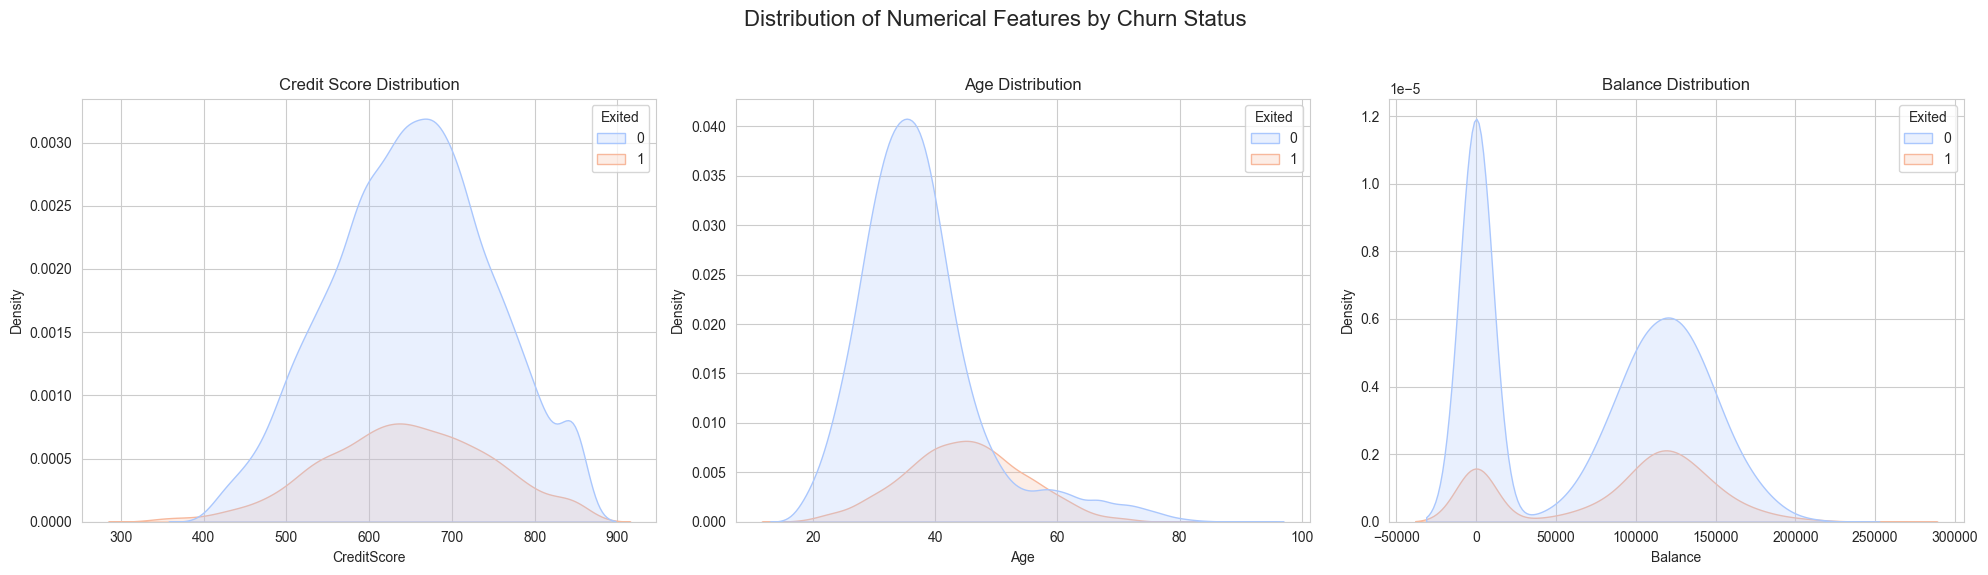

In [17]:
# --- NUMERICAL FEATURE ANALYSIS ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of Numerical Features by Churn Status', fontsize=16)

# Plot for Credit Score
sns.kdeplot(data=df, x='CreditScore', hue='Exited', fill=True, palette='coolwarm', ax=axes[0])
axes[0].set_title('Credit Score Distribution')

# Plot for Age
sns.kdeplot(data=df, x='Age', hue='Exited', fill=True, palette='coolwarm', ax=axes[1])
axes[1].set_title('Age Distribution')

# Plot for Balance
sns.kdeplot(data=df, x='Balance', hue='Exited', fill=True, palette='coolwarm', ax=axes[2])
axes[2].set_title('Balance Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

### 2.2 Geographical Churn Analysis (Map Visualization)

To better understand the geographical impact, we will visualize the churn rate by country using a choropleth map. This provides a much more intuitive view than a simple bar chart.

*Note: This requires the `plotly` library. If you haven't installed it, please run `pip install plotly` in your terminal.*

In [18]:
# --- GEOGRAPHICAL CHURN ANALYSIS (IMPROVED ZOOM) ---
import plotly.express as px

# Calculate churn rate by country
country_churn_rate = df.groupby('Geography')['Exited'].mean().reset_index()
print("Churn Rate by Country:")
print(country_churn_rate)

# Create the choropleth map
fig = px.choropleth(country_churn_rate,
                    locations='Geography',
                    locationmode='country names',
                    color='Exited',
                    scope='europe',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Customer Churn Rate Across Europe',
                    fitbounds="locations" 
                   )

fig.show()

Churn Rate by Country:
  Geography    Exited
0    France  0.161548
1   Germany  0.324701
2     Spain  0.166734


### Key Insights from Exploratory Data Analysis (EDA)

Based on the initial visualizations, we can draw several important conclusions that will guide our feature engineering and modeling steps:

1.  **Significant Class Imbalance:** The dataset is imbalanced, with only about **20.4%** of customers having churned (`Exited = 1`). This is a critical consideration for our modeling phase, as a naive model could achieve high accuracy by simply predicting "No Churn". We will need to use appropriate evaluation metrics later on.

2.  **Demographic Indicators of Churn:**
    * **Geography:** Customers in **Germany** exhibit a noticeably higher churn rate compared to those in France and Spain.
    * **Gender:** **Female** customers in this dataset have a higher tendency to churn than male customers.
    * **Age:** There is a clear pattern related to age. The churn rate is highest among middle-aged customers, typically between **40 and 60 years old**.

3.  **Financial Behavior Patterns:**
    * **Account Balance:** Interestingly, customers with a substantial account balance are more likely to churn. A large group of customers with a zero balance has a very high retention rate, a counter-intuitive finding that might suggest these are lower-engagement but stable accounts.

These initial findings provide a strong foundation and highlight key features (`Geography`, `Gender`, `Age`, `Balance`) that will likely be important predictors in our machine learning model.

## 3. Data Preprocessing and Feature Engineering

Before training a model, we need to process the data into a suitable format. This involves:
1.  Dropping irrelevant columns that do not contribute to a customer's decision to churn.
2.  Converting categorical features (like `Geography` and `Gender`) into a numerical format using one-hot encoding.

In [19]:
# --- DATA PREPROCESSING ---

# Drop columns that are not useful for prediction
df_processed = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])
print("Dropped irrelevant columns.")

# --- NEW: Handle missing values BEFORE encoding ---
# Fill missing 'Age' with the median age
df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
# Fill missing 'HasCrCard' with the mode (most frequent value)
df_processed['HasCrCard'].fillna(df_processed['HasCrCard'].mode()[0], inplace=True)
print("Filled NaN values in 'Age' and 'HasCrCard' columns.")

# Convert categorical features into numerical format using one-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['Geography', 'Gender'], drop_first=True)
print("Encoded categorical features.")

# Display the first 5 rows of the processed dataframe
print("\n--- Processed DataFrame Head ---")
df_processed.head()

Dropped irrelevant columns.
Filled NaN values in 'Age' and 'HasCrCard' columns.
Encoded categorical features.

--- Processed DataFrame Head ---


/var/folders/1l/w0l2h4b54p9blc640vdwhzmh0000gn/T/ipykernel_26410/251268516.py:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/1l/w0l2h4b54p9blc640vdwhzmh0000gn/T/ipykernel_26410/251268516.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,1,False,False,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,0,False,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,1,False,False,False
3,699,39.0,1,0.00,2,0.0,0.0,93826.63,0,False,False,False
4,850,43.0,2,125510.82,1,1.0,1.0,79084.10,0,False,True,False


## 4. Data Splitting and Feature Scaling

With the data fully preprocessed, we will now prepare it for modeling. This involves three key steps:

1.  **Feature/Target Separation:** We will separate our dataset into features (X) and the target variable (y, which is `Exited`).
2.  **Train-Test Split:** We will then divide the data into a training set (to teach the model) and a testing set (to evaluate its performance on unseen data).
3.  **Feature Scaling:** We will scale the features to ensure they are on a similar range. This is crucial for many machine learning algorithms to perform optimally.

In [20]:
# --- PREPROCESSING, SPLITTING, AND SCALING ---

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Preprocessing
print("Starting data preprocessing...")
df_processed = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Handle ALL missing values
for col in ['Geography', 'HasCrCard', 'IsActiveMember']:
    if df_processed[col].isnull().any():
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

if df_processed['Age'].isnull().any():
    df_processed['Age'].fillna(df_processed['Age'].median(), inplace=True)
print("Filled all identified NaN values.")

# One-Hot Encoding
df_processed = pd.get_dummies(df_processed, columns=['Geography', 'Gender'], drop_first=True)
print("Encoded categorical features.")

# 2. Splitting
X = df_processed.drop(columns=['Exited'])
y = df_processed['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")

# 3. Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Feature scaling complete.")

print("\n--- Final Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Starting data preprocessing...
Filled all identified NaN values.
Encoded categorical features.
Data split into training and testing sets.
Feature scaling complete.

--- Final Shapes ---
X_train shape: (8001, 11)
X_test shape: (2001, 11)


/var/folders/1l/w0l2h4b54p9blc640vdwhzmh0000gn/T/ipykernel_26410/369632607.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/1l/w0l2h4b54p9blc640vdwhzmh0000gn/T/ipykernel_26410/369632607.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

## 5. Model Training & Evaluation

Now that the data is prepared, we can begin the modeling phase. We will train and evaluate two different models to compare their performance.

### 5.1 Baseline Model: Logistic Regression

We'll use Logistic Regression as our baseline model because it's simple, interpretable, and provides a good starting point for classification tasks.

In [21]:
# --- MODEL TRAINING: LOGISTIC REGRESSION ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Initialize and train the model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# 2. Make predictions on the test set
y_pred_lr = log_reg_model.predict(X_test)

# 3. Evaluate the model's performance
print(f"--- Logistic Regression Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

--- Logistic Regression Model Evaluation ---
Accuracy: 0.8091

Confusion Matrix:
[[1534   65]
 [ 317   85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1599
           1       0.57      0.21      0.31       402

    accuracy                           0.81      2001
   macro avg       0.70      0.59      0.60      2001
weighted avg       0.78      0.81      0.77      2001

